# Analyse Flows

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame as DF
import matplotlib.pyplot as plt
import scipy.io
import scipy
# import mat73 # load mat as dict
import networkx as nx
import pandapower as pp
import pandapower.converter as ppc
import pandapower.plotting as ppp

PATH_SAVE = 'graphics/MATLAB_runopf_results'
fig_size_normal = (10,4)
fig_size_large = (20,7)

In [3]:
# load case
caseTurkish = pd.read_excel('data/caseTurkish.xlsx', header=[0], sheet_name=['generators', 'branches', 'buses'])

# load additional data
data = dict()
data['capacity source type (MW)'] = pd.read_excel('data/data_selected.xlsx', header=[0], sheet_name=['capacity source type (MW)'])['capacity source type (MW)']
data['Transmission Lines'] = pd.read_excel('data/data_selected.xlsx', header=[0], sheet_name=['Transmission Lines'])['Transmission Lines']
#data['Counties Hourly Demand'] = pd.read_excel('data/Counties Hourly Demand.xlsx', header=[0], sheet_name=['population and coordinates'])['population and coordinates']

### Display graph

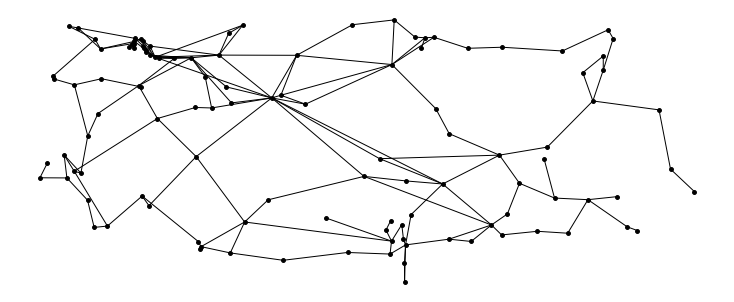

In [4]:
df = data['capacity source type (MW)']
nodes = df['Substation Nodes']
edges = [(n1,n2) for n1,n2,_ in np.array(data['Transmission Lines'])]

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

coordinates = {str(nodes[i]) : (df.loc[i, 'Longitude'], df.loc[i, 'Latitude']) for i in df.index}
nx.set_node_attributes(G, coordinates, 'coord')

labels = {i : str(nodes[i]) for i in df.index}
G = nx.relabel_nodes(G, labels)

plt.figure(figsize=fig_size_normal) 
nx.draw(G, coordinates, node_color='black', node_size=15)
plt.savefig(PATH_SAVE + '/caseTurkish_substations.png')
plt.show()

In [5]:
nodes

0                  ADANA_Ceyhan
1                ADANA_Imamoglu
2                   ADANA_Kozan
3              ADANA_Tufanbeyli
4              ADANA_Yumurtalik
                 ...           
111    TEKIRDAG_Marmaraereglisi
112                 VAN_Baskale
113                   VAN_Tusba
114            ZONGULDAK_Eregli
115            ZONGULDAK_Merkez
Name: Substation Nodes, Length: 116, dtype: object

In [6]:
edges

[('ISTANBUL_Eyup', 'KIRKLARELI_Luleburgaz'),
 ('KIRKLARELI_Babaeski', 'KIRKLARELI_Luleburgaz'),
 ('KIRKLARELI_Luleburgaz', 'TEKIRDAG_Marmaraereglisi'),
 ('KIRKLARELI_Babaeski', 'TEKIRDAG_Corlu'),
 ('TEKIRDAG_Corlu', 'CANAKKALE_Gelibolu'),
 ('TEKIRDAG_Corlu', 'TEKIRDAG_Marmaraereglisi'),
 ('TEKIRDAG_Corlu', 'TEKIRDAG_Marmaraereglisi'),
 ('ISTANBUL_Sultangazi', 'TEKIRDAG_Marmaraereglisi'),
 ('ISTANBUL_Basaksehir', 'TEKIRDAG_Marmaraereglisi'),
 ('ISTANBUL_Basaksehir', 'TEKIRDAG_Marmaraereglisi'),
 ('ISTANBUL_Sultangazi', 'ISTANBUL_Basaksehir'),
 ('KOCAELI_Gebze', 'ISTANBUL_Sultangazi'),
 ('ISTANBUL_Sultangazi', 'ISTANBUL_Sariyer'),
 ('ISTANBUL_Basaksehir', 'ISTANBUL_Avcilar'),
 ('ISTANBUL_Esenler', 'ISTANBUL_Basaksehir'),
 ('ISTANBUL_Esenler', 'ISTANBUL_Basaksehir'),
 ('ISTANBUL_Esenler', 'ISTANBUL_Bahcelievler'),
 ('ISTANBUL_Esenler', 'ISTANBUL_Bagcilar'),
 ('ISTANBUL_Eyup', 'ISTANBUL_Beykoz'),
 ('ISTANBUL_Eyup', 'ISTANBUL_Umraniye'),
 ('ISTANBUL_Eyup', 'ISTANBUL_Bagcilar'),
 ('ISTANBUL_

### Helper functions

In [144]:
# helper function that convertes bus numbers to names from the dataset
def bus_nr_to_dataset_names(numbers):
    df = caseTurkish['buses']
    l = []
    for i in numbers:
        l.append(df['bus_name_dataset'][i-1])
    return l

In [145]:
def extract_from_mat(mat):
    
    # buses, generation, branches
    mat_bus = mat['mpc'][0][0][2]
    mat_gen = mat['mpc'][0][0][3]
    mat_branch = mat['mpc'][0][0][4]
    
    # mat -> python
    mat_bus[:,0] = mat_bus[:,0].astype(int)-1
    mat_gen[:,0] = mat_gen[:,0].astype(int)-1
    mat_branch[:,[0,1]] = mat_branch[:,[0,1]].astype(int)-1 
    
    # loads, line flow, rateA
    loads = mat_bus[:,2]
    gen_absolute = mat_gen[:,1]
    gen_capacity = mat_gen[:,8]
    line_flow = mat_branch[:,15]
    rateA = mat_branch[:,5] 
    
    return loads, gen_absolute, gen_capacity, line_flow, rateA

In [146]:
def sort_nodes(G):
    G_new = nx.Graph()
    G_new.add_nodes_from(sorted(G.nodes(data=True)))
    G_new.add_edges_from(G.edges(data=True))
    return G_new

In [147]:
def get_unc_stor(opf_results):
    #uncertainties = [59,47,55,41,52]
    uncertainties = opf_results['uncertainties'].tolist()
    uncertainties = uncertainties if type(uncertainties)!=int else [uncertainties]
    uncertainties = [u-1 for u in uncertainties]
    #storages = [4,6,7,8]
    storages = extract_results(opf_results, 'storages', 6) if 'storages' in opf_results.keys() else []
    storages = [s-1 for s in storages]
    return uncertainties, storages

In [148]:
def get_coords(G, df, nrs=False):
    coordinates = dict()
    for n in G.nodes:
        idx = n
        if not nrs:
            idx = df[df['Substation Nodes']==n].index[0]
        coordinates[n] = df.loc[idx, 'Longitude'], df.loc[idx, 'Latitude']
    coordinates = {e: coordinates[e] for e in list(np.unique(list(coordinates.keys())))}
    nx.set_node_attributes(G, coordinates, 'coord')
    return G, coordinates

In [149]:
def extract_results(mat_file, kind, t=6, mean_var="mean"):
    assert kind in mat_file.keys(), "Wrong kind."
    d = mat_file[kind][mean_var]
    return {int(bus.split("_")[1]) : ts[t] for bus, ts in d.items()}

In [150]:
def plot_Turkey(case='caseTurkish_StorageAtWind', case_mat='caseTurkish_dataset', nr_unc_stor='10+10', storage='NoStorage', var=None, t=6, loc_glob='local', LAB=False, LAB_nrs=False, \
                show_wind=True, show_gen=True, show_stor=True, show_load=True, show_lineflows=True, whole_graph_plot=True, zoom_plot=True, save_name='', figsize=(10,5), factor=100, line_col='k'):

    plt.rcParams['text.usetex'] = False

    opf_results = mat73.loadmat('Results/Paper2_Workshop_Turkish/'+case+'/'+nr_unc_stor+'/ExportedResults/Results_DCsOPF_'+storage+'_'+loc_glob+'.mat')

    df = data['capacity source type (MW)']
    mat = scipy.io.loadmat('casefiles/results_'+case_mat+'_mpc.mat')

    case_pp = ppc.from_mpc('casefiles/results_'+case_mat+'_mpc.mat')
    G = pp.topology.create_nxgraph(case_pp)
    G = sort_nodes(G)

    loads, gen_absolute, gen_capacity, line_flow, rateA = extract_from_mat(mat)
    uncertainties, storages = get_unc_stor(opf_results)
    
    # labels
    G_nrs = G.copy()
    labels_name = {n : bus_nr_to_dataset_names([n+1])[0] for n in list(G.nodes)}
    labels_name2 = {bus_nr_to_dataset_names([n+1])[0] : bus_nr_to_dataset_names([n+1])[0].split('_')[1] for n in list(G.nodes)}
    G = nx.relabel_nodes(G, labels_name)
    labels_nrs = {n : list(G_nrs.nodes)[i] for i,n in enumerate(list(G.nodes))}
    
    G, coordinates_case = get_coords(G, df)
    G_nrs, coordinates_case_nrs = get_coords(G_nrs, df, nrs=True)

    ##############################
    # results
    results_gen_ = extract_results(opf_results, 'generators', t)
    results_gen = [results_gen_[i] if i in results_gen_.keys() else 0 for i in range(1,len(G.nodes())+1)]
    results_loads_ = extract_results(opf_results, 'load', t, 'mean')
    results_loads = {bus_nr_to_dataset_names([i])[0]:-results_loads_[i] if (i in results_loads_.keys() and results_loads_[i] < 0) else 0 for i in range(1,len(G.nodes())+1)}
    results_wind = [results_loads_[i] if (i in results_loads_.keys() and results_loads_[i] > 0) else 0 for i in range(1,len(G.nodes())+1)]
    results_lines_ = extract_results(opf_results, 'lines', t)
    results_lines = [results_lines_[i] if i in results_lines_.keys() else 0 for i in range(1,len(G.edges())+1)]
    if storage == 'Storage':
        results_storages_ = extract_results(opf_results, 'storages', t)
        results_storages = [results_storages_[i] if i in results_storages_.keys() else 0 for i in range(1,len(G.nodes())+1)]
    edge_labels = {list(G.edges())[i] : '$<$ '+str(np.abs(l)) if l<0 else str(np.abs(l))+' $>$' for i,l in enumerate(np.round(results_lines,2))}
    
    ##############################
    # offset coordinates
    offset = 0.05
    coord_labels = {k:(v[0]+offset,v[1]+offset) for k,v in coordinates_case.items()}
    offset_stor = 0.15
    coord_stor = {k:(v[0]-offset_stor,v[1]) for k,v in coordinates_case.items()}    
    offset_wind = 0.15
    coord_wind = {k:(v[0]-offset_wind-0.04,v[1]+offset_wind+0.02) for k,v in coordinates_case.items()}
    offset_wind2 = 0.05
    coord_wind2 = {k:(v[0]-offset_wind2-0.04,v[1]+offset_wind2+0.02) for k,v in coordinates_case.items()}
    coord_wind_gen = {k:(v[0]-offset_wind,v[1]) for k,v in coordinates_case_nrs.items()}
    offset_stor_lab = 0.12
    coord_stor_lab = {k:(v[0]-offset_stor_lab,v[1]-offset_stor_lab) for k,v in coordinates_case_nrs.items()}
    labels = {bus_nr_to_dataset_names([k+1])[0]:k+1 for k,v in coordinates_case_nrs.items()}
    #max_gen_color = ['blue' if e!=0 else 'blue' for e in max_gen]
    unc_sizes_gen = [650 if i in uncertainties else 0 for i,e in enumerate(results_gen) ]
    if storage=='Storage':
        sizes_stor = [500 if i in storages else 0 for i,e in enumerate(results_storages) ]
    col=line_col

    # ============== PLOT ======================================
    a = 0.5
    SHOW_NRS = False
    if whole_graph_plot:
        plt.figure(figsize=figsize)
        nx.draw(G, coordinates_case, with_labels=False, font_size=10, node_size=1, node_color=col, edge_color='gray', font_color='k')
        if LAB:
            nx.draw_networkx_labels(G, coord_labels, labels=labels_name2, font_color='k', font_size=15)
        if LAB_nrs:
            nx.draw_networkx_labels(G, coord_labels, labels=labels, font_color='k', font_size=20)
        if show_stor and storage=='Storage':
            print("Sum of storage:", np.sum(results_storages))
            nx.draw_networkx_nodes(G, coordinates_case, node_color='green', alpha=a, node_size=np.multiply(results_storages,150), node_shape='o') # storage
            #nx.draw_networkx_nodes(G, coord_stor, node_color='olive', node_size=sizes_stor, node_shape='$stor$') # unc gen
        if show_wind:
            print("Sum of wind:", np.sum(results_wind))
            #nx.draw_networkx_nodes(G, coord_wind, node_color='blue', node_size=unc_sizes_gen, node_shape='$wind$') # unc gen
            nx.draw_networkx_nodes(G, coordinates_case, node_color='blue', alpha=a, node_size=np.multiply(results_wind,factor), node_shape='o')#10) # 8 = triangle left
        if show_load:
            print("Sum of loads:", np.sum(list(results_loads.values())))
            nx.draw_networkx_nodes(G, coordinates_case, node_color='red', alpha=a, node_size=np.multiply(list(results_loads.values()),factor), node_shape='o')#11) # 8 = triangle left
        if show_gen:
            print("Sum of generation:", np.sum(results_gen))
            nx.draw_networkx_nodes(G, coordinates_case, node_color='cornflowerblue', alpha=a, node_size=np.multiply(results_gen,factor), node_shape='o')#10) # 9 = triangle right
        if show_lineflows:
            nx.draw_networkx_edges(G, coordinates_case, edge_color=col, width=np.multiply(results_lines,1))
        if SHOW_NRS:
            nx.draw_networkx_edge_labels(G, coordinates_case, edge_labels = edge_labels, font_color = col, font_size=20)

        plt.margins(0.15)
        plt.savefig('graphics/MATLAB_runopf_results/'+case+'_'+storage+'_'+nr_unc_stor+'_allInOne_Graph_diff_t='+str(t)+'_'+save_name+'.png')
        plt.show()

    if zoom_plot:
        subgraph_nodes = ['KIRKLARELI_Luleburgaz', 'ISTANBUL_Sultangazi', 'ISTANBUL_Basaksehir', 'ISTANBUL_Eyup', 'DUZCE_Merkez', 'ISTANBUL_Sancaktepe', 'ISTANBUL_Avcilar', 'TEKIRDAG_Marmaraereglisi', 'KOCAELI_Gebze', 'KOCAELI_Izmit', 'SAKARYA_Adapazari']
        subgraph_idx = [list(G.nodes()).index(e) for e in subgraph_nodes]
        subgraph_edge_idx = [(a,b) for (a,b) in G.edges() if (a in subgraph_nodes and b in subgraph_nodes)]
        coordinates_case = {key: coordinates_case[key] for key in subgraph_nodes}
        coord_wind = {key: coord_wind[key] for key in subgraph_nodes}
        coord_wind2 = {key: coord_wind2[key] for key in subgraph_nodes}
        coord_stor = {key: val for key,val in coord_stor.items() if key in subgraph_nodes}
        coord_labels = {key: val for key,val in coord_labels.items() if key in subgraph_nodes}
        unc_sizes_gen = [e for i,e in enumerate(unc_sizes_gen) if i in subgraph_idx]
        results_loads = [e for key, e in results_loads.items() if key in subgraph_nodes]
        results_wind = [e for i,e in enumerate(results_wind) if i in subgraph_idx]
        results_gen = [e for i,e in enumerate(results_gen) if i in subgraph_idx]
        labels = {key: labels[key] for key in subgraph_nodes}
        labels_name2 = {key: labels_name2[key] for key in subgraph_nodes}
        if storage=='Storage':
            results_storages = [e for i,e in enumerate(results_storages) if i in subgraph_idx]
            sizes_stor = [e for i,e in enumerate(sizes_stor) if i in subgraph_idx]

        G = G.subgraph(subgraph_nodes)
        plt.figure(figsize=figsize)
        nx.draw(G, coordinates_case, with_labels=False, node_size=2, node_color='gray', edge_color=line_col)
        if LAB:
            nx.draw_networkx_labels(G, coord_labels, labels=labels_name2, font_color='k', font_size=15)
        if LAB_nrs:
            nx.draw_networkx_labels(G, coord_labels, labels=labels, font_color='k', font_size=20)
        if show_stor and storage=='Storage':
            nx.draw_networkx_nodes(G, coordinates_case, node_color='green', alpha=a, node_size=np.multiply(results_storages,factor), node_shape='o') # storage
            #nx.draw_networkx_nodes(G, coord_stor, node_color='olive', node_size=sizes_stor, node_shape='$stor$') # unc gen
        if show_wind:
            #nx.draw_networkx_nodes(G, coord_wind2, node_color='blue', alpha=a, node_size=unc_sizes_gen, node_shape='$wind$') # unc gen
            nx.draw_networkx_nodes(G, coordinates_case, node_color='blue', alpha=a, node_size=np.multiply(results_wind,factor), node_shape='o')#10) # 8 = triangle left
        if show_load:
            nx.draw_networkx_nodes(G, coordinates_case, node_color='red', alpha=a, node_size=np.multiply(results_loads,factor), node_shape='o')#11) # 8 = triangle left
        if show_gen:
            nx.draw_networkx_nodes(G, coordinates_case, node_color='lightblue', alpha=a, node_size=np.multiply(results_gen,factor), node_shape='o')#10) # 9 = triangle right
        if show_lineflows:
            nx.draw_networkx_edges(G, coordinates_case, edge_color=col, width=np.multiply(results_lines,1))
        plt.margins(0.15)
        plt.savefig('graphics/MATLAB_runopf_results/'+case+'_'+storage+'_'+nr_unc_stor+'_allInOne_Graph_diff_t='+str(t)+'_'+save_name+'_zoom.png')
        plt.show()

In [151]:
def plot_Turkey2(case='caseTurkish_StorageAtWind', case_mat='caseTurkish_dataset', nr_unc_stor='10+10', storage='NoStorage', var=None, t=6, loc_glob='local', LAB=False, LAB_nrs=False, \
                show_wind=True, show_gen=True, show_stor=True, show_load=True, show_lineflows=True, whole_graph_plot=True, zoom_plot=True, save_name='', figsize=(10,5), factor=100, line_col='k'):

    plt.rcParams['text.usetex'] = False

    opf_results = mat73.loadmat('Results/Paper2_Workshop_Turkish/'+case+'/'+nr_unc_stor+'/ExportedResults/Results_DCsOPF_'+storage+'_'+loc_glob+'.mat')

    df = data['capacity source type (MW)']
    mat = scipy.io.loadmat('casefiles/results_'+case_mat+'_mpc.mat')

    case_pp = ppc.from_mpc('casefiles/results_'+case_mat+'_mpc.mat')
    G = pp.topology.create_nxgraph(case_pp)
    G = sort_nodes(G)

    loads, gen_absolute, gen_capacity, line_flow, rateA = extract_from_mat(mat)
    uncertainties, storages = get_unc_stor(opf_results)
    
    # labels
    G_nrs = G.copy()
    labels_name = {n : bus_nr_to_dataset_names([n+1])[0] for n in list(G.nodes)}
    labels_name2 = {bus_nr_to_dataset_names([n+1])[0] : bus_nr_to_dataset_names([n+1])[0].split('_')[1] for n in list(G.nodes)}
    G = nx.relabel_nodes(G, labels_name)
    labels_nrs = {n : list(G_nrs.nodes)[i] for i,n in enumerate(list(G.nodes))}
    
    G, coordinates_case = get_coords(G, df)
    G_nrs, coordinates_case_nrs = get_coords(G_nrs, df, nrs=True)

    ##############################
    # results
    results_gen_ = extract_results(opf_results, 'generators', t)
    results_gen = [results_gen_[i] if i in results_gen_.keys() else 0 for i in range(1,len(G.nodes())+1)]
    results_loads_ = extract_results(opf_results, 'load', t, 'mean')
    results_loads = {bus_nr_to_dataset_names([i])[0]:-results_loads_[i] if (i in results_loads_.keys() and results_loads_[i] < 0) else 0 for i in range(1,len(G.nodes())+1)}
    results_wind = [results_loads_[i] if (i in results_loads_.keys() and results_loads_[i] > 0) else 0 for i in range(1,len(G.nodes())+1)]
    results_lines_ = extract_results(opf_results, 'lines', t)
    results_lines = [results_lines_[i] if i in results_lines_.keys() else 0 for i in range(1,len(G.edges())+1)]
    if storage == 'Storage':
        results_storages_ = extract_results(opf_results, 'storages', t)
        results_storages = [results_storages_[i] if i in results_storages_.keys() else 0 for i in range(1,len(G.nodes())+1)]
    edge_labels = {list(G.edges())[i] : '$<$ '+str(np.abs(l)) if l<0 else str(np.abs(l))+' $>$' for i,l in enumerate(np.round(results_lines,2))}
    
    ##############################
    # offset coordinates
    offset = 0.05
    coord_labels = {k:(v[0]+offset,v[1]+offset) for k,v in coordinates_case.items()}
    offset_stor = 0.15
    coord_stor = {k:(v[0]-offset_stor,v[1]) for k,v in coordinates_case.items()}    
    offset_wind = 0.15
    coord_wind = {k:(v[0]-offset_wind-0.04,v[1]+offset_wind+0.02) for k,v in coordinates_case.items()}
    offset_wind2 = 0.05
    coord_wind2 = {k:(v[0]-offset_wind2-0.04,v[1]+offset_wind2+0.02) for k,v in coordinates_case.items()}
    coord_wind_gen = {k:(v[0]-offset_wind,v[1]) for k,v in coordinates_case_nrs.items()}
    offset_stor_lab = 0.12
    coord_stor_lab = {k:(v[0]-offset_stor_lab,v[1]-offset_stor_lab) for k,v in coordinates_case_nrs.items()}
    labels = {bus_nr_to_dataset_names([k+1])[0]:k+1 for k,v in coordinates_case_nrs.items()}
    #max_gen_color = ['blue' if e!=0 else 'blue' for e in max_gen]
    unc_sizes_gen = [650 if i in uncertainties else 0 for i,e in enumerate(results_gen) ]
    if storage=='Storage':
        sizes_stor = [500 if i in storages else 0 for i,e in enumerate(results_storages) ]
    col=line_col

    # ============== PLOT ======================================
    a = 0.5
    SHOW_NRS = False
    if whole_graph_plot:
        plt.figure(figsize=figsize)
        nx.draw(G, coordinates_case, with_labels=False, font_size=10, node_size=1, node_color=col, edge_color='gray', font_color='k')
        if LAB:
            nx.draw_networkx_labels(G, coord_labels, labels=labels_name2, font_color='k', font_size=15)
        if LAB_nrs:
            nx.draw_networkx_labels(G, coord_labels, labels=labels, font_color='k', font_size=20)
        if show_stor and storage=='Storage':
            print("Sum of storage:", np.sum(results_storages))
            nx.draw_networkx_nodes(G, coordinates_case, node_color='green', node_size=np.multiply([0 if e==0 else 1 for e in results_storages],150), node_shape='o') # storage
            #nx.draw_networkx_nodes(G, coord_stor, node_color='olive', node_size=sizes_stor, node_shape='$stor$') # unc gen
        if show_wind:
            print("Sum of wind:", np.sum(results_wind))
            #nx.draw_networkx_nodes(G, coord_wind, node_color='blue', node_size=unc_sizes_gen, node_shape='$wind$') # unc gen
            nx.draw_networkx_nodes(G, coordinates_case, node_color='blue', node_size=np.multiply([0 if e==0 else 1 for e in results_wind],factor), node_shape='o')#10) # 8 = triangle left
        if show_load:
            print("Sum of loads:", np.sum(list(results_loads.values())))
            nx.draw_networkx_nodes(G, coordinates_case, node_color='red', node_size=np.multiply([0 if e==0 else 1 for e in list(results_loads.values())],factor), node_shape='o')#11) # 8 = triangle left
        if show_gen:
            print("Sum of generation:", np.sum(results_gen))
            nx.draw_networkx_nodes(G, coordinates_case, node_color='cornflowerblue', node_size=np.multiply([0 if e==0 else 1 for e in results_gen],factor), node_shape='o')#10) # 9 = triangle right
        if show_lineflows:
            nx.draw_networkx_edges(G, coordinates_case, edge_color=col, width=np.multiply(results_lines,1))
        if SHOW_NRS:
            nx.draw_networkx_edge_labels(G, coordinates_case, edge_labels = edge_labels, font_color = col, font_size=20)

        plt.margins(0.15)
        plt.savefig('graphics/MATLAB_runopf_results/'+case+'_'+storage+'_'+nr_unc_stor+'_allInOne_Graph_diff_t='+str(t)+'_'+save_name+'.png')
        plt.show()

    if zoom_plot:
        subgraph_nodes = ['KIRKLARELI_Luleburgaz', 'ISTANBUL_Sultangazi', 'ISTANBUL_Basaksehir', 'ISTANBUL_Eyup', 'DUZCE_Merkez', 'ISTANBUL_Sancaktepe', 'ISTANBUL_Avcilar', 'TEKIRDAG_Marmaraereglisi', 'KOCAELI_Gebze', 'KOCAELI_Izmit', 'SAKARYA_Adapazari']
        subgraph_idx = [list(G.nodes()).index(e) for e in subgraph_nodes]
        subgraph_edge_idx = [(a,b) for (a,b) in G.edges() if (a in subgraph_nodes and b in subgraph_nodes)]
        coordinates_case = {key: coordinates_case[key] for key in subgraph_nodes}
        coord_wind = {key: coord_wind[key] for key in subgraph_nodes}
        coord_wind2 = {key: coord_wind2[key] for key in subgraph_nodes}
        coord_stor = {key: val for key,val in coord_stor.items() if key in subgraph_nodes}
        coord_labels = {key: val for key,val in coord_labels.items() if key in subgraph_nodes}
        unc_sizes_gen = [e for i,e in enumerate(unc_sizes_gen) if i in subgraph_idx]
        results_loads = [e for key, e in results_loads.items() if key in subgraph_nodes]
        results_wind = [e for i,e in enumerate(results_wind) if i in subgraph_idx]
        results_gen = [e for i,e in enumerate(results_gen) if i in subgraph_idx]
        labels = {key: labels[key] for key in subgraph_nodes}
        labels_name2 = {key: labels_name2[key] for key in subgraph_nodes}
        if storage=='Storage':
            results_storages = [e for i,e in enumerate(results_storages) if i in subgraph_idx]
            sizes_stor = [e for i,e in enumerate(sizes_stor) if i in subgraph_idx]

        G = G.subgraph(subgraph_nodes)
        plt.figure(figsize=figsize)
        nx.draw(G, coordinates_case, with_labels=False, node_size=2, node_color='gray', edge_color=line_col)
        if LAB:
            nx.draw_networkx_labels(G, coord_labels, labels=labels_name2, font_color='k', font_size=15)
        if LAB_nrs:
            nx.draw_networkx_labels(G, coord_labels, labels=labels, font_color='k', font_size=20)
        if show_stor and storage=='Storage':
            nx.draw_networkx_nodes(G, coordinates_case, node_color='green', alpha=a, node_size=np.multiply([0 if e==0 else 1 for e in results_storages],factor), node_shape='o') # storage
            #nx.draw_networkx_nodes(G, coord_stor, node_color='olive', node_size=sizes_stor, node_shape='$stor$') # unc gen
        if show_wind:
            #nx.draw_networkx_nodes(G, coord_wind2, node_color='blue', alpha=a, node_size=unc_sizes_gen, node_shape='$wind$') # unc gen
            nx.draw_networkx_nodes(G, coordinates_case, node_color='blue', alpha=a, node_size=np.multiply([0 if e==0 else 1 for e in results_wind],factor), node_shape='o')#10) # 8 = triangle left
        if show_load:
            nx.draw_networkx_nodes(G, coordinates_case, node_color='red', alpha=a, node_size=np.multiply([0 if e==0 else 1 for e in results_loads],factor), node_shape='o')#11) # 8 = triangle left
        if show_gen:
            nx.draw_networkx_nodes(G, coordinates_case, node_color='lightblue', alpha=a, node_size=np.multiply([0 if e==0 else 1 for e in results_gen],factor), node_shape='o')#10) # 9 = triangle right
        if show_lineflows:
            nx.draw_networkx_edges(G, coordinates_case, edge_color=col, width=np.multiply(results_lines,1))
        plt.margins(0.15)
        plt.savefig('graphics/MATLAB_runopf_results/'+case+'_'+storage+'_'+nr_unc_stor+'_allInOne_Graph_diff_t='+str(t)+'_'+save_name+'_zoom.png')
        plt.show()

### Plot results

In [338]:
opf_results = mat73.loadmat('Results/Paper2_Workshop_Turkish/caseTurkish_StorageAtWind/10+10/ExportedResults/Results_DCsOPF_Storage_local.mat')


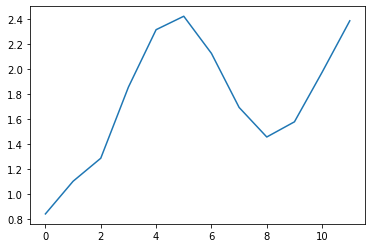

In [344]:
plt.plot(opf_results['load']['mean']['bus_1'])

In [187]:
# setup
case = 'caseTurkish_StorageInMiddle_FewerStorage'
case = 'caseTurkish_StorageAtWind'
#case = 'caseTurkish_StorageFarFromWind'
nr_unc_stor = '10+10'
figsize=(6,3)
factor = 70
t=5
storage='Storage'

Sum of storage: 32.782117762081924
Sum of wind: 23.6709038184602
Sum of loads: 93.10348080950398
Sum of generation: 65.23428772243707


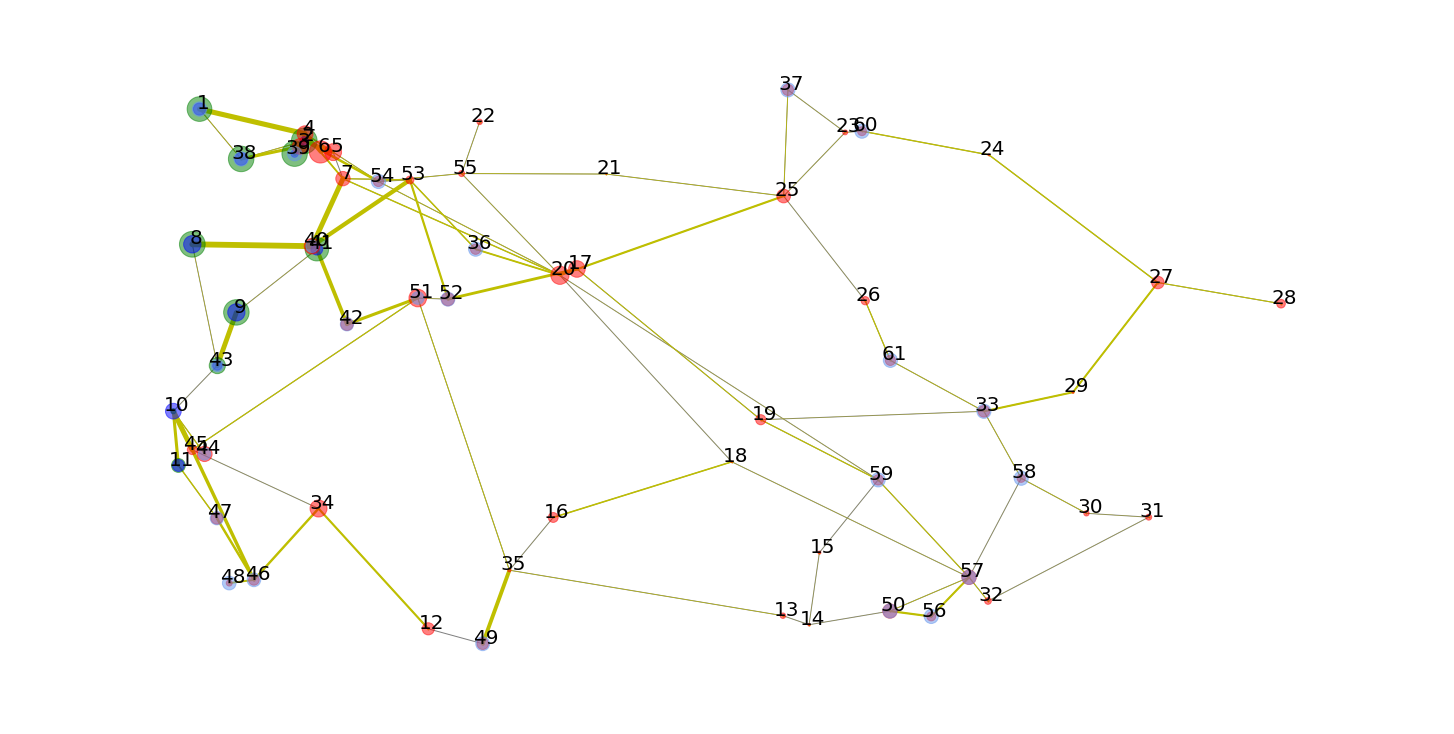

In [152]:
# plot whole graph
plot_Turkey(case=case, case_mat='caseTurkish_dataset', nr_unc_stor=nr_unc_stor, storage=storage, var=None, t=t, loc_glob='local', LAB_nrs=True, LAB=False, \
            show_wind=True, show_gen=True, show_stor=True, show_load=True, show_lineflows=True, whole_graph_plot=True, zoom_plot=False, factor=factor, figsize=(20,10), line_col='y', save_name='')

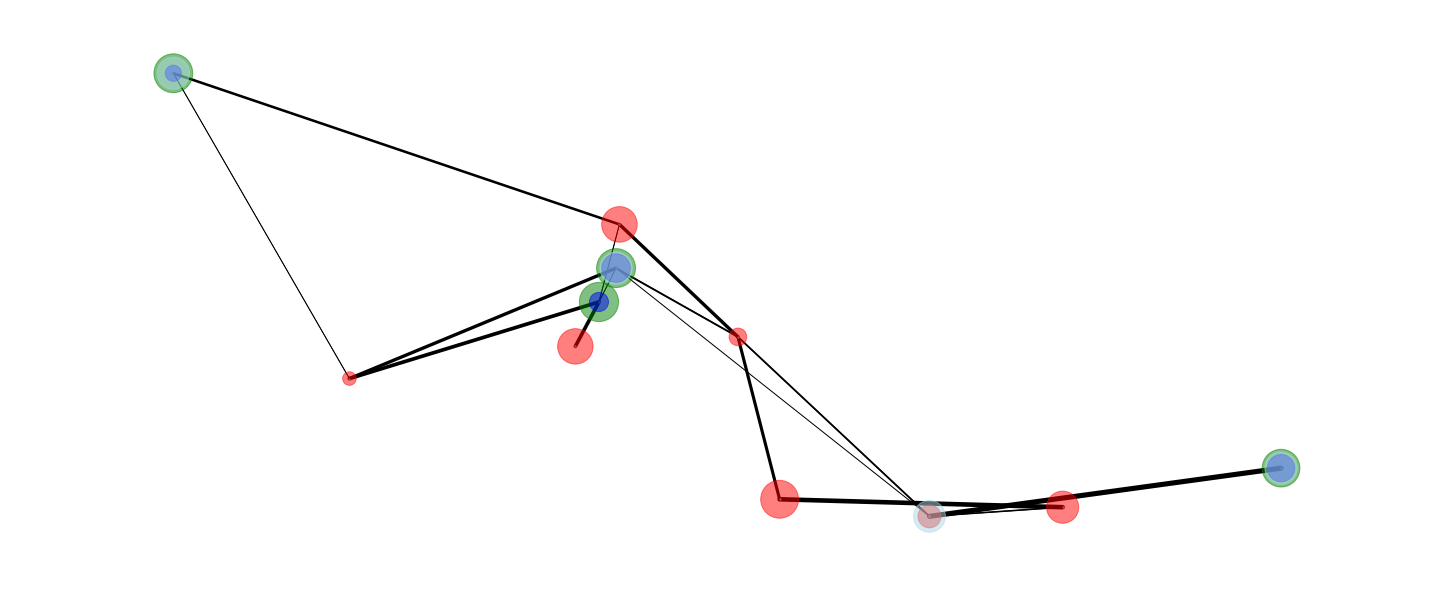

In [153]:
# plot whole graph
plot_Turkey(case=case, case_mat='caseTurkish_dataset', nr_unc_stor=nr_unc_stor, storage=storage, var=None, t=t, loc_glob='local', LAB=False, \
            show_wind=True, show_gen=True, show_stor=True, show_load=True, show_lineflows=True, whole_graph_plot=False, zoom_plot=True, factor=factor*5, figsize=(20,8), line_col='k', save_name='')

Sum of wind: 23.6709038184602


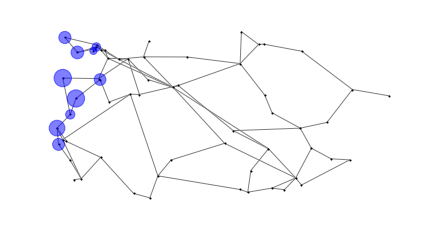

In [154]:
plot_Turkey(case=case, case_mat='caseTurkish_dataset', nr_unc_stor=nr_unc_stor, storage=storage, var=None, t=t, loc_glob='local', LAB=False, \
            show_wind=True, show_gen=False, show_stor=False, show_load=False, show_lineflows=False, zoom_plot=False, save_name='wind', figsize=figsize, factor=factor)

Sum of wind: 23.6709038184602


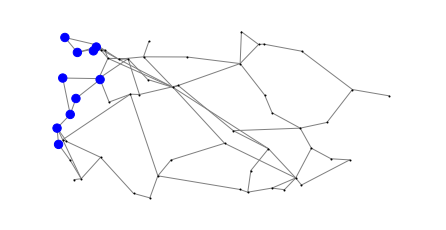

In [155]:
plot_Turkey2(case=case, case_mat='caseTurkish_dataset', nr_unc_stor=nr_unc_stor, storage=storage, var=None, t=t, loc_glob='local', LAB=False, \
            show_wind=True, show_gen=False, show_stor=False, show_load=False, show_lineflows=False, zoom_plot=False, save_name='wind_loc', figsize=figsize, factor=factor)

Sum of generation: 65.23428772243707


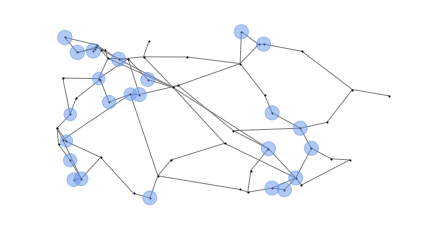

In [156]:
plot_Turkey(case=case, case_mat='caseTurkish_dataset', nr_unc_stor=nr_unc_stor, storage=storage, var=None, t=t, loc_glob='local', LAB=False,\
            show_wind=False, show_gen=True, show_stor=False, show_load=False, show_lineflows=False, zoom_plot=False, save_name='generation', figsize=figsize, factor=factor)

Sum of generation: 65.23428772243707


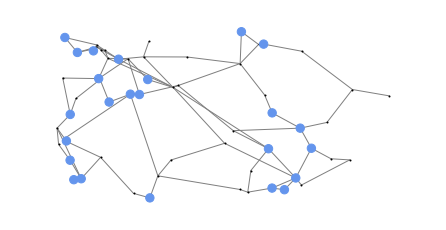

In [157]:
plot_Turkey2(case=case, case_mat='caseTurkish_dataset', nr_unc_stor=nr_unc_stor, storage=storage, var=None, t=t, loc_glob='local', LAB=False,\
            show_wind=False, show_gen=True, show_stor=False, show_load=False, show_lineflows=False, zoom_plot=False, save_name='generation_loc', figsize=figsize, factor=factor)

Sum of loads: 93.10348080950398


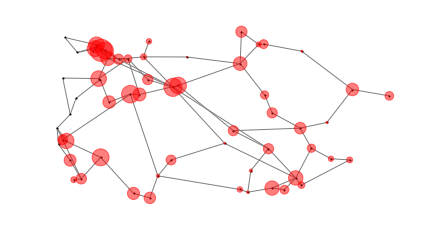

In [158]:
plot_Turkey(case=case, case_mat='caseTurkish_dataset', nr_unc_stor=nr_unc_stor, storage=storage, var=None, t=t, loc_glob='local', LAB=False, \
            show_wind=False, show_gen=False, show_stor=False, show_load=True, show_lineflows=False, zoom_plot=False, save_name='loads', figsize=figsize, factor=factor)

Sum of loads: 93.10348080950398


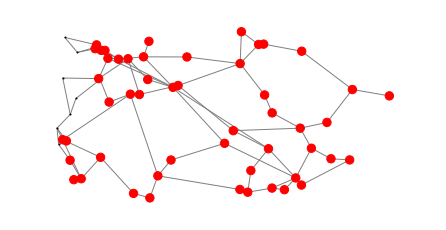

In [159]:
plot_Turkey2(case=case, case_mat='caseTurkish_dataset', nr_unc_stor=nr_unc_stor, storage=storage, var=None, t=t, loc_glob='local', LAB=False, \
            show_wind=False, show_gen=False, show_stor=False, show_load=True, show_lineflows=False, zoom_plot=False, save_name='loads_loc', figsize=figsize, factor=factor)

Sum of storage: 34.64380359790938


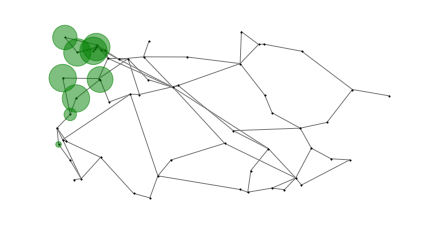

In [188]:
plot_Turkey(case='caseTurkish_StorageAtWind', case_mat='caseTurkish_dataset', nr_unc_stor='10+10', storage='Storage', var=None, t=t, loc_glob='local', LAB=False, \
            show_wind=False, show_gen=False, show_stor=True, show_load=False, show_lineflows=False, zoom_plot=False, save_name='storage', figsize=figsize, factor=factor)

Sum of storage: 28.330916509817257


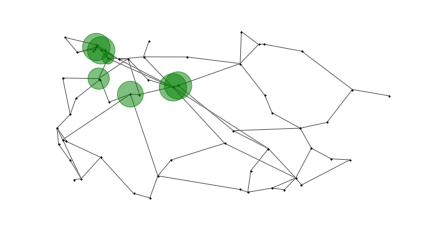

In [189]:
plot_Turkey(case='caseTurkish_StorageInMiddle_FewerStorage', case_mat='caseTurkish_dataset', nr_unc_stor='10+7', storage='Storage', var=None, t=t, loc_glob='local', LAB=False, \
            show_wind=False, show_gen=False, show_stor=True, show_load=False, show_lineflows=False, zoom_plot=False, save_name='storage', figsize=figsize, factor=factor)

Sum of storage: 35.81522608477898


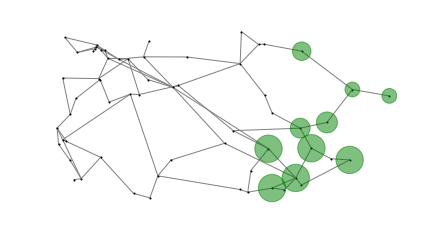

In [190]:
plot_Turkey(case='caseTurkish_StorageFarFromWind', case_mat='caseTurkish_dataset', nr_unc_stor='10+10', storage='Storage', var=None, t=t, loc_glob='local', LAB=False, \
            show_wind=False, show_gen=False, show_stor=True, show_load=False, show_lineflows=False, zoom_plot=False, save_name='storage', figsize=figsize, factor=factor)

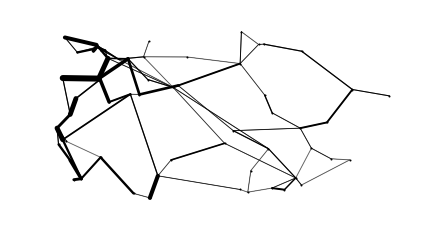

In [171]:
plot_Turkey(case='caseTurkish_StorageAtWind', case_mat='caseTurkish_dataset', nr_unc_stor='10+10', storage=storage, var=None, t=t, loc_glob='local', LAB=False, \
            show_wind=False, show_gen=False, show_stor=False, show_load=False, show_lineflows=True, zoom_plot=False, save_name='line_flows', figsize=figsize, factor=factor)

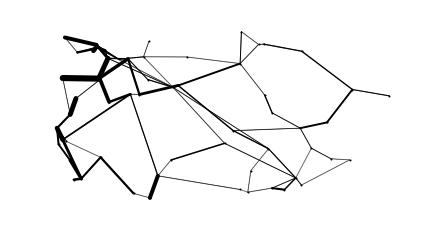

In [172]:
plot_Turkey(case='caseTurkish_StorageInMiddle_FewerStorage', case_mat='caseTurkish_dataset', nr_unc_stor='10+7', storage=storage, var=None, t=t, loc_glob='local', LAB=False, \
            show_wind=False, show_gen=False, show_stor=False, show_load=False, show_lineflows=True, zoom_plot=False, save_name='line_flows', figsize=figsize, factor=factor)

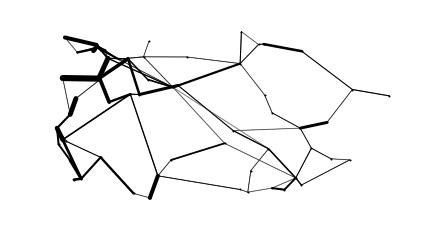

In [173]:
plot_Turkey(case='caseTurkish_StorageFarFromWind', case_mat='caseTurkish_dataset', nr_unc_stor='10+10', storage=storage, var=None, t=t, loc_glob='local', LAB=False, \
            show_wind=False, show_gen=False, show_stor=False, show_load=False, show_lineflows=True, zoom_plot=False, save_name='line_flows', figsize=figsize, factor=factor)

### Plot lines in bars

In [21]:
len(opf_results_StorageAtWind['lines']['mean'].keys())

91

In [79]:
new_dict = dict(sorted(lines_StorageAtWind.items(), key=lambda item: item[1]))
new_dict.keys()

dict_keys([9, 17, 75, 24, 5, 71, 39, 8, 46, 28, 70, 45, 81, 73, 62, 82, 61, 36, 74, 23, 50, 3, 56, 31, 72, 15, 79, 38, 42, 66, 86, 47, 18, 68, 59, 67, 64, 51, 91, 83, 53, 65, 52, 69, 58, 20, 34, 63, 43, 14, 54, 32, 57, 84, 41, 22, 33, 13, 48, 29, 35, 90, 87, 40, 89, 30, 37, 60, 2, 55, 49, 12, 44, 10, 26, 16, 27, 85, 80, 88, 7, 11, 6, 78, 77, 4, 76, 21, 25, 1, 19])

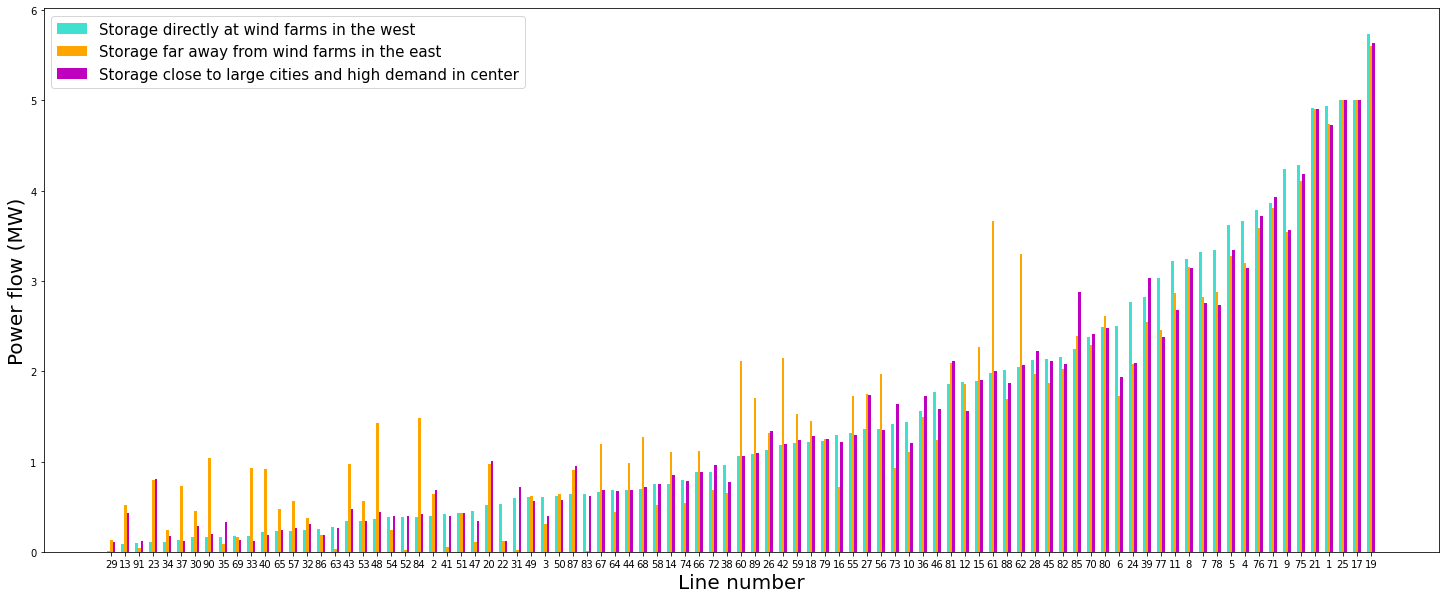

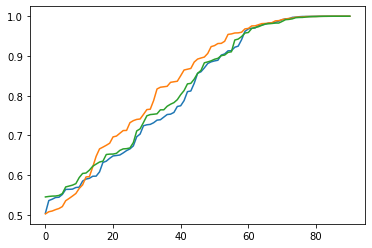

In [140]:
opf_results_StorageAtWind = mat73.loadmat('Results/Paper2_Workshop_Turkish/caseTurkish_StorageAtWind/10+10/ExportedResults/Results_DCsOPF_Storage_local.mat')
opf_results_StorageFarFromWind = mat73.loadmat('Results/Paper2_Workshop_Turkish/caseTurkish_StorageFarFromWind/10+10/ExportedResults/Results_DCsOPF_Storage_local.mat')
opf_results_StorageInMiddle = mat73.loadmat('Results/Paper2_Workshop_Turkish/caseTurkish_StorageInMiddle_FewerStorage/10+7/ExportedResults/Results_DCsOPF_Storage_local.mat')

df = []

for t in range(12):
    lines_StorageAtWind = extract_results(opf_results_StorageAtWind, 'lines', t=t, mean_var="mean")
    lines_StorageFarFromWind = extract_results(opf_results_StorageFarFromWind, 'lines', t=t, mean_var="mean")
    lines_StorageInMiddle = extract_results(opf_results_StorageInMiddle, 'lines', t=t, mean_var="mean")
    
    loads = extract_results(opf_results_StorageAtWind, 'load', t=t, mean_var="mean")
    lines_StorageAtWind_sorted = dict(sorted(lines_StorageAtWind.items(), key=lambda item: np.abs(item[1])))

    #lines_StorageAtWind_ = [lines_StorageAtWind[i] for i in range(1,92)]
    lines_StorageAtWind_ = np.abs([lines_StorageAtWind[i] for i in lines_StorageAtWind_sorted.keys()])
    lines_StorageFarFromWind_ = np.abs([lines_StorageFarFromWind[i] for i in lines_StorageAtWind_sorted.keys()])
    lines_StorageInMiddle_ = np.abs([lines_StorageInMiddle[i] for i in lines_StorageAtWind_sorted.keys()])
    
    loads_ = [loads[i] for i in range(1,62)]
    
    df.append([np.sum(lines_StorageAtWind_), np.sum(lines_StorageFarFromWind_), np.sum(lines_StorageInMiddle_)])
    
    if False:
        plt.figure(figsize=(25,10))
        x = np.arange(len(lines_StorageFarFromWind_))
        plt.bar(x-0.2, lines_StorageAtWind_, 0.2, color='turquoise', label='Storage directly at wind farms in the west')
        plt.bar(x, lines_StorageFarFromWind_, 0.2, color='orange', label='Storage far away from wind farms in the east')
        plt.bar(x+0.2, lines_StorageInMiddle_, 0.2, color='m', label='Storage close to large cities and high demand in center')
        plt.legend(fontsize=15)
        plt.xlabel('Line number', fontsize=20)
        plt.xticks(list(range(92)))
        plt.ylabel('Power flow (MW)', fontsize=20)
        plt.savefig(str('graphics/MATLAB_runopf_results/LineDifferences_t='+str(t)+'.png'))
        plt.show()
        
if True:
    t = 5
    
    lines_StorageAtWind = extract_results(opf_results_StorageAtWind, 'lines', t=t, mean_var="mean")
    lines_StorageFarFromWind = extract_results(opf_results_StorageFarFromWind, 'lines', t=t, mean_var="mean")
    lines_StorageInMiddle = extract_results(opf_results_StorageInMiddle, 'lines', t=t, mean_var="mean")
    
    loads = extract_results(opf_results_StorageAtWind, 'load', t=t, mean_var="mean")
    lines_StorageAtWind_sorted = dict(sorted(lines_StorageAtWind.items(), key=lambda item: np.abs(item[1])))
    lines_StorageFarFromWind_sorted = dict(sorted(lines_StorageFarFromWind.items(), key=lambda item: np.abs(item[1])))
    lines_StorageInMiddle_sorted = dict(sorted(lines_StorageInMiddle.items(), key=lambda item: np.abs(item[1])))

    #lines_StorageAtWind_ = [lines_StorageAtWind[i] for i in range(1,92)]
    lines_StorageAtWind_ = np.abs([lines_StorageAtWind[i] for i in lines_StorageAtWind_sorted.keys()])
    lines_StorageFarFromWind_ = np.abs([lines_StorageFarFromWind[i] for i in lines_StorageAtWind_sorted.keys()])
    lines_StorageInMiddle_ = np.abs([lines_StorageInMiddle[i] for i in lines_StorageAtWind_sorted.keys()])
    
    cdf1 = scipy.stats.norm.cdf(lines_StorageAtWind_)
    cdf2 = scipy.stats.norm.cdf(np.abs([lines_StorageFarFromWind[i] for i in lines_StorageFarFromWind_sorted.keys()]))
    cdf3 = scipy.stats.norm.cdf(np.abs([lines_StorageInMiddle[i] for i in lines_StorageInMiddle_sorted.keys()]))
    
    fig = plt.figure(figsize=(25,10))
    x = np.arange(len(lines_StorageFarFromWind_))
    x2 = np.array(list(lines_StorageAtWind_sorted.keys()))
    plt.bar(x-0.2, lines_StorageAtWind_, 0.2, color='turquoise', label='Storage directly at wind farms in the west')
    plt.bar(x, lines_StorageFarFromWind_, 0.2, color='orange', label='Storage far away from wind farms in the east')
    plt.bar(x+0.2, lines_StorageInMiddle_, 0.2, color='m', label='Storage close to large cities and high demand in center')
    plt.legend(fontsize=15)
    plt.xlabel('Line number', fontsize=20)
    plt.xticks(x, labels=x2)
    plt.ylabel('Power flow (MW)', fontsize=20)
    plt.savefig(str('graphics/MATLAB_runopf_results/LineDifferences_t='+str(t)+'.png'))
    plt.show()
    
    fig = plt.figure()
    plt.plot(cdf1)
    plt.plot(cdf2)
    plt.plot(cdf3)
    plt.show()

In [34]:
loads_sum = [-np.sum(list(extract_results(opf_results_StorageAtWind, 'load', t=t, mean_var="mean").values())) for t in range(12)]

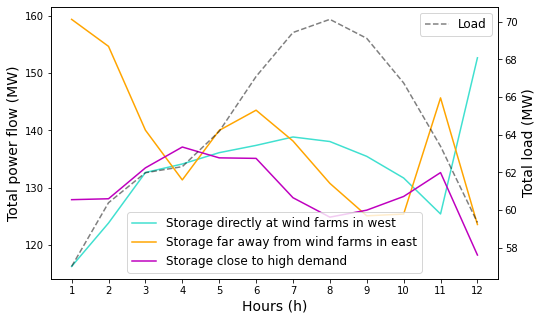

In [186]:
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot([e[0] for e in df], c='turquoise', label='Storage directly at wind farms in west')
ax1.plot([e[1] for e in df], c='orange', label='Storage far away from wind farms in east')
ax1.plot([e[2] for e in df], c='m', label='Storage close to high demand')
ax2 = ax1.twinx()
ax2.plot(loads_sum, c='k', alpha=0.5, ls='dashed', label='Load')
ax1.legend(loc='lower center', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)
ax1.set_xlabel('Hours (h)', fontsize=14)
ax1.set_ylabel('Total power flow (MW)', fontsize=14)
ax2.set_ylabel('Total load (MW)', fontsize=14)
plt.xticks(range(12), labels=range(1,13))
plt.savefig('graphics/MATLAB_runopf_results/TotalLineFlow.png')
plt.show()

#### In what case is highest line flow?

In [167]:
np.sum(np.abs(lines_StorageAtWind_)), np.sum(np.abs(lines_StorageFarFromWind_)), np.sum(np.abs(lines_StorageInMiddle_)), t

(138.8419408267171, 140.83024316875475, 128.2516302636353, 6)

In [162]:
np.sum(np.abs(lines_StorageAtWind_)), np.sum(np.abs(lines_StorageFarFromWind_)), np.sum(np.abs(lines_StorageInMiddle_)), t

(123.83131682359623, 140.47722936680586, 128.06907093524126)

## Results Analysis

In [21]:
mat = scipy.io.loadmat('casefiles/'+'results_'+'caseTurkish_dataset'+'_mpc'+'.mat')

In [22]:
# MAT OPF
# 0,0,2 nodes 61x17
# 0,0,3 generators 24x25
# 0,0,4 lines 91x21
# 0,0,5 gen. costs 24x7
mat_bus = mat['mpc'][0][0][2]
mat_gen = mat['mpc'][0][0][3]
mat_branch = mat['mpc'][0][0][4]

In [23]:
# JULIA OPF
file = 'Results/Paper2_Workshop_Turkish/caseTurkish_firstpaperDraft/caseTurkish_distributedStorages/Results_DCsOPF_Storage_local.mat'
mat_results = mat73.loadmat(file)
#mat_results_gen = mat_results['generators']['mean']
#mat_results_stor = mat_results['storages']['mean']
#mat_results_load = mat_results['load']

In [24]:
def extract_Pg_time_t(mat_gen, t=0, baseMVA=100):
    d = mat_gen
    mat_Pg = np.array([[int(el.replace('bus_','')), d[el]] for el in list(d.keys())])
    mat_Pg_t = [(mat_Pg[i][0], mat_Pg[i][1][t]) for i in range(len(mat_Pg))]
    mat_Pg_t.sort(key=lambda tup: tup[0])
    mat_Pg_t_onlyPg = np.array([(mat_Pg_t[i][0], mat_Pg_t[i][1]*baseMVA) for i in range(len(mat_Pg_t))])
    mat_Pg_t_onlyPg[:,0] = mat_Pg_t_onlyPg[:,0].astype(int)
    return mat_Pg_t_onlyPg 

def plot_network_limits_DIFFERENCE(mat_file='results_caseTurkish_dataset_mpc', file_directory='caseTurkish_distributedStorages', file_directory2='caseTurkish_distributedStorages', DCsOPF_file1='Results_DCsOPF_NoStorage_global', DCsOPF_file2='Results_DCsOPF_Storage_global'):

    baseMVA = 100
    t = 6
    
    # load capacities & .mat casefile
    df = data['capacity source type (MW)']
    mat = scipy.io.loadmat('casefiles/'+mat_file+'.mat')
    mat_results =  mat73.loadmat('Results/Paper2_Workshop_Turkish/caseTurkish_firstPaperDraft/'+file_directory+"/"+DCsOPF_file1+'.mat')
    mat_results2 =  mat73.loadmat('Results/Paper2_Workshop_Turkish/caseTurkish_firstPaperDraft/'+file_directory2+"/"+DCsOPF_file2+'.mat')
    uncertainties = mat_results['uncertainties']
    if 'storages' in mat_results2.keys():
        storages = extract_Pg_time_t(mat_results2['storages']['mean'], 6, 100)[:,0].astype(int)
    else:
        storages = []
    
    # create graph from .mat casefile
    case = ppc.from_mpc('casefiles/'+mat_file+'.mat')
    G = pp.topology.create_nxgraph(case)
    
    # extract buses, generators and branches
    mat_bus = mat['mpc'][0][0][2]
    #mat_gen = mat['mpc'][0][0][3]
    mat_branch = mat['mpc'][0][0][4]
    # NEW RESULTS
    mat_results_gen = mat_results['generators']['mean']
    mat_results_gen2 = mat_results2['generators']['mean']
    
    # relabel indices
    # MATLAB (starts counting at 1) --> Python (starts counting at 0)
    mat_bus[:,0] = mat_bus[:,0].astype(int)-1
    mat_gen[:,0] = mat_gen[:,0].astype(int)-1
    mat_branch[:,[0,1]] = mat_branch[:,[0,1]].astype(int)-1 
    uncertainties = [u-1 for u in uncertainties]
    storages = [s-1 for s in storages]
    
    # ------------ LABELS (node names & nrs) --------------------
    G_nrs = G.copy()
    labels_nrs = {n : n for n in list(G.nodes)}
    G_nrs = nx.relabel_nodes(G_nrs, labels_nrs)
    labels_name = {n : bus_nr_to_dataset_names([n+1])[0] for n in list(G.nodes)}
    G = nx.relabel_nodes(G, labels_name)
    labels_nrs = {n : list(G_nrs.nodes)[i] for i,n in enumerate(list(G.nodes))}

    # ------------ COORDINATES --------------------
    # coordinates (names)
    coordinates_case = dict()
    for n in G.nodes:
        idx = df[df['Substation Nodes']==n].index[0]
        coordinates_case[n] = df.loc[idx, 'Longitude'], df.loc[idx, 'Latitude']
    coordinates_case = {e: coordinates_case[e] for e in list(np.unique(list(coordinates_case.keys())))}
    nx.set_node_attributes(G, coordinates_case, 'coord')
    
    # coordinates (numbers)
    coordinates_case_nrs = dict()
    for n in G_nrs.nodes:
        coordinates_case_nrs[n] = df.loc[n, 'Longitude'], df.loc[n, 'Latitude']
    coordinates_case_nrs = {e: coordinates_case_nrs[e] for e in list(np.unique(list(coordinates_case_nrs.keys())))}
    nx.set_node_attributes(G_nrs, coordinates_case_nrs, 'coord')

    # ------------ LOADS --------------------
    #loads = mat_bus[:,2]
    loads = extract_Pg_time_t(mat_results['load'], t, baseMVA)[:,1] * (-1)
    loads_labels = {name : loads[nr].astype(int) for name,nr in zip(list(G.nodes), list(G_nrs.nodes))}
    node_size_loads = list(loads_labels.values())
    pos_labels = {k : (v[0]+0.2,v[1]+0.2) for k,v in coordinates_case.items()}
    pos_labels_nrs = {k : (v[0]-0.2,v[1]-0.2) for k,v in coordinates_case.items()}
    
    # ------------ GENERATION --------------------
    
    # generation
    gen_diff = np.zeros(len(mat_bus))
    gen_bus_nrs = extract_Pg_time_t(mat_results_gen, t, baseMVA)[:,0].astype(int) - 1 # JULIA -> PYTHON
    gen_diff[gen_bus_nrs] = abs(extract_Pg_time_t(mat_results_gen, t, baseMVA)[:,1] - extract_Pg_time_t(mat_results_gen2, t, baseMVA)[:,1])
    gen_labels = {nr : gen_diff[nr] for nr in list(G_nrs.nodes)}
    node_size_gen = list(gen_labels.values())

    # ------------ LINE FLOWs & CAPACITIES --------------------
    G_lines = nx.Graph()
    G_lines.add_nodes_from(G.nodes)
    
    # line flow
    mat_buses = mat_branch
    line_flow_diff = abs(extract_Pg_time_t(mat_results['lines']['mean'], t)[:,1]) - abs(extract_Pg_time_t(mat_results2['lines']['mean'], t)[:,1])
    for i,e in enumerate(G.edges):
        G_lines.add_edge(e[0],e[1],weight=line_flow_diff[i])
        
    edge_color_line_flow_diff = ['red' if e>0 else 'lime' for e in line_flow_diff]
        
    rateA = mat_branch[:,5] # rate A
    
    # ------------ STORAGES & UNCERTAINTIES --------------------
    uncertainty_labels = DF(np.zeros(len(mat_bus)), index=list(G_nrs.nodes),columns=['0'])
    uncertainty_labels.loc[uncertainties] = 100
    storage_labels = DF(np.zeros(len(mat_bus)), index=list(G_nrs.nodes),columns=['0'])
    storage_labels.loc[storages] = 200

    # ============== PLOT ======================================
    a = 3
    b = 1.5
    c = 0.1
    plt.figure(figsize=(23,12)) 
    nx.draw(G, coordinates_case, node_color='white', with_labels=False, font_size=10, edge_color='white', font_color='k', node_size=1)
    # labels
    #nx.draw_networkx_labels(G, pos_labels, labels=loads_labels, font_color='gray', font_size=20)
    #nx.draw_networkx_labels(G, pos_labels_nrs, labels=labels_nrs)
    # edges
    nx.draw_networkx_edges(G, coordinates_case, node_size=0, edge_color='lightsteelblue', width=rateA*c, alpha=0.2)
    nx.draw_networkx_edges(G, coordinates_case, edge_color=edge_color_line_flow_diff, width=line_flow_diff * c, alpha=0.7)
    # nodes
    #nx.draw_networkx_nodes(G, coordinates_case, node_color='khaki', node_size=np.multiply(node_size_loads,a), node_shape=8) # 8 = triangle left
    nx.draw_networkx_nodes(G, coordinates_case, node_size=np.multiply(storage_labels['0'],a), node_color='lightsteelblue', node_shape='o', alpha=0.5)
    nx.draw_networkx_nodes(G, coordinates_case, node_size=np.multiply(uncertainty_labels['0'],b), node_color='lightsteelblue', node_shape='o', alpha=0.5) # '$unc.$'
    nx.draw_networkx_nodes(G, coordinates_case, node_color='black', node_size=np.multiply(node_size_gen,a), node_shape=9) # 9 = triangle right
    #plt.title('Matpower results '+name)
    plt.savefig(PATH_SAVE + '/'+file_directory+"_"+DCsOPF_file1+'-'+DCsOPF_file2+'_OPF_results_DIFFERENCE')
    plt.show()

<ipython-input-24-eac39f125109>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mat_Pg = np.array([[int(el.replace('bus_','')), d[el]] for el in list(d.keys())])


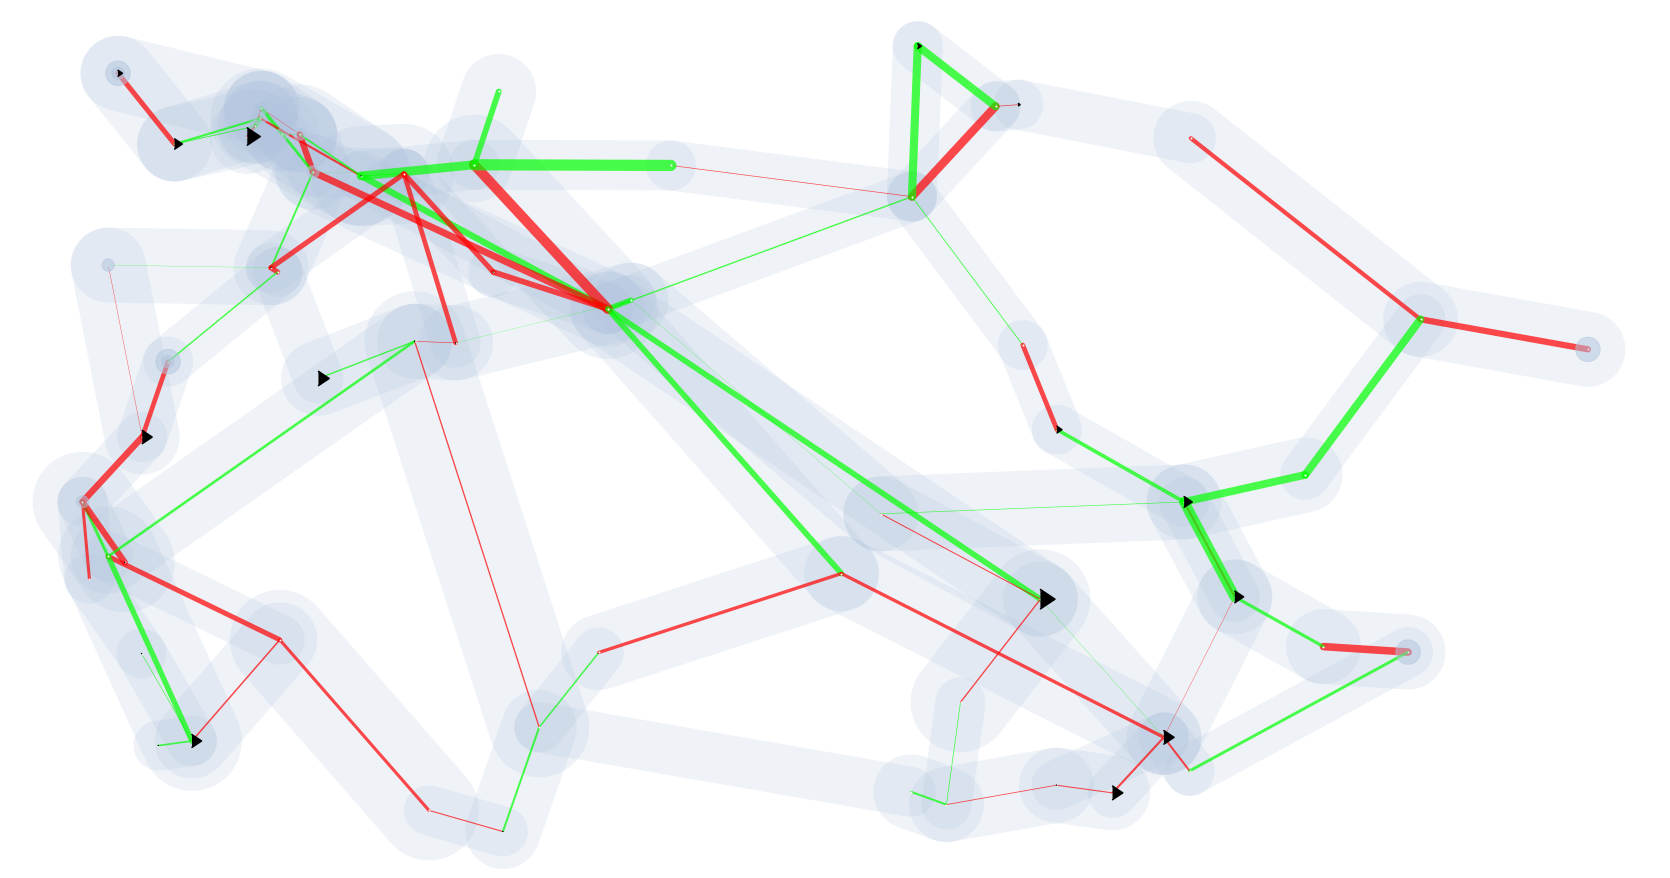

In [25]:
mat_file='results_caseTurkish_dataset_mpc'
file_directory='caseTurkish_distributedStorages'
file_directory2='caseTurkish_StoragesCloseToLoad'
DCsOPF_file1, DCsOPF_file2 = 'Results_DCsOPF_NoStorage_local', 'Results_DCsOPF_Storage_local'
DCsOPF_file1, DCsOPF_file2 = 'Results_DCsOPF_NoStorage_global', 'Results_DCsOPF_Storage_global'
DCsOPF_file1, DCsOPF_file2 = 'Results_DCsOPF_Storage_local', 'Results_DCsOPF_Storage_local'
#DCsOPF_file1, DCsOPF_file2 = 'Results_DCsOPF_Storage_global_withVariance', 'Results_DCsOPF_Storage_local_withVariance'
plot_network_limits_DIFFERENCE(mat_file, file_directory, file_directory2, DCsOPF_file1, DCsOPF_file2)

In [26]:
def extract_Pg_time_t(mat_gen, t=0, baseMVA=100):
    d = mat_gen
    mat_Pg = np.array([[int(el.replace('bus_','')), d[el]] for el in list(d.keys())])
    mat_Pg_t = [(mat_Pg[i][0], mat_Pg[i][1][t]) for i in range(len(mat_Pg))]
    mat_Pg_t.sort(key=lambda tup: tup[0])
    mat_Pg_t_onlyPg = np.array([(mat_Pg_t[i][0], mat_Pg_t[i][1]*baseMVA) for i in range(len(mat_Pg_t))])
    mat_Pg_t_onlyPg[:,0] = mat_Pg_t_onlyPg[:,0].astype(int)
    return mat_Pg_t_onlyPg 

def plot_network_limits_RESULTS_FROM_JULIA(path='graphics/DCsOPF_results/Turkish_firstPaperDraft', mat_file='results_caseTurkish_dataset_mpc', file_directory='caseTurkish_distributedStorages', DCsOPF_file='Results_DCsOPF_NoStorage_global'):

    baseMVA = 100
    t = 6
    
    # capacities
    df            = data['capacity source type (MW)']
    
    # .mat file
    mat           = scipy.io.loadmat('casefiles/'+mat_file+'.mat')
    mat_results   = mat73.loadmat(path+'/'+file_directory+"/"+DCsOPF_file+'.mat')
    #uncertainties = mat_results['uncertainties']
    uncertainties = [1,38,39,54,8,9,53,41,42,43,45,47,48,34,49,14,13,59]
    if 'storages' in mat_results.keys():
        storages = extract_Pg_time_t(mat_results['storages']['mean'], 6, 100)[:,0].astype(int)
    else:
        storages = []
    
    # graph
    case = ppc.from_mpc('casefiles/'+mat_file+'.mat')
    G    = pp.topology.create_nxgraph(case)
    
    # buses, generators and branches
    mat_bus         = mat['mpc'][0][0][2]
    mat_gen         = mat['mpc'][0][0][3]
    mat_branch      = mat['mpc'][0][0][4]
    mat_results_gen = mat_results['generators']['mean'] # new
    
    # relabel indices
    # MATLAB (starts counting at 1) --> Python (starts counting at 0)
    uncertainties       = [u-1 for u in uncertainties]
    storages            = [s-1 for s in storages]
    mat_bus[:,0]        = mat_bus[:,0].astype(int)-1
    mat_gen[:,0]        = mat_gen[:,0].astype(int)-1
    mat_branch[:,[0,1]] = mat_branch[:,[0,1]].astype(int)-1 
    print(np.sort(uncertainties))
    
    # ------------ LABELS (node names & nrs) --------------------
    G_nrs = G.copy()
    labels_nrs = {n : n for n in list(G.nodes)}
    G_nrs = nx.relabel_nodes(G_nrs, labels_nrs)
    labels_name = {n : bus_nr_to_dataset_names([n+1])[0] for n in list(G.nodes)}
    G = nx.relabel_nodes(G, labels_name)
    labels_nrs = {n : list(G_nrs.nodes)[i] for i,n in enumerate(list(G.nodes))}

    # ------------ COORDINATES --------------------
    # coordinates (names)
    print(G.nodes())
    print(len(G.nodes()))
    coordinates_case = dict()
    for n in G.nodes:
        idx = df[df['Substation Nodes']==n].index[0]
        coordinates_case[n] = df.loc[idx, 'Longitude'], df.loc[idx, 'Latitude']
    coordinates_case = {e: coordinates_case[e] for e in list(np.unique(list(coordinates_case.keys())))}
    nx.set_node_attributes(G, coordinates_case, 'coord')
    
    # coordinates (numbers)
    coordinates_case_nrs = dict()
    for n in G_nrs.nodes:
        coordinates_case_nrs[n] = df.loc[n, 'Longitude'], df.loc[n, 'Latitude']
    coordinates_case_nrs = {e: coordinates_case_nrs[e] for e in list(np.unique(list(coordinates_case_nrs.keys())))}
    nx.set_node_attributes(G_nrs, coordinates_case_nrs, 'coord')

    # ------------ LOADS --------------------
    #loads = mat_bus[:,2]
    loads = extract_Pg_time_t(mat_results['load']['mean'], t, baseMVA)[:,1] * (-1)
    loads_labels = {name : loads[nr].astype(int) for name,nr in zip(list(G.nodes), list(G_nrs.nodes))}
    node_size_loads = list(loads_labels.values())
    pos_labels = {k : (v[0]+0.2,v[1]+0.2) for k,v in coordinates_case.items()}
    pos_labels_nrs = {k : (v[0]-0.2,v[1]-0.2) for k,v in coordinates_case.items()}
    
    # ------------ GENERATION --------------------
    
    # generation
    gen = np.zeros(len(mat_bus))
    #gen[mat_gen[:,0].astype(int)] = mat_gen[:,1]
    gen_bus_nrs = extract_Pg_time_t(mat_results_gen, t, baseMVA)[:,0].astype(int) - 1 # JULIA -> PYTHON
    gen[gen_bus_nrs] = extract_Pg_time_t(mat_results_gen, t, baseMVA)[:,1]
    gen_labels = {nr : gen[nr] for nr in list(G_nrs.nodes)}
    node_size_gen = list(gen_labels.values())
    
    # max gen
    color1, color2 = 'orange', 'darkorange'
    #gen_abs = mat_gen[:,1]
    gen_abs = extract_Pg_time_t(mat_results_gen, t, baseMVA)[:,1]
    gen_cap = mat_gen[:,8]
    max_gen = []
    j = 0
    for i in range(len(mat_bus)):
        if i in mat_gen[:,0].astype(int):
            if gen_abs[j] > gen_cap[j]*0.98:
                max_gen.append(color2)
            else:
                max_gen.append(color1)
            j = j+1
        else:
            max_gen.append(color1)
    max_gen

    # ------------ LINE FLOWs & CAPACITIES --------------------
    G_lines = nx.Graph()
    G_lines.add_nodes_from(G.nodes)
    
    # line flow
    c = 0.03
    #line_flow = mat_branch[:,15]*c # flow fbus to tbus
    line_flow = abs(extract_Pg_time_t(mat_results['lines']['mean'], t)[:,1])
    for i,e in enumerate(G.edges):
        G_lines.add_edge(e[0],e[1],weight=line_flow[i])
        
    # line capacities
    rateA = mat_branch[:,5] # rate A
    max_flow_ = [line_flow[i] > rateA[i]*0.98 for i in range(len(rateA))]
    max_flow = ['midnightblue' if e else 'royalblue' for e in max_flow_]
    
    # ------------ STORAGES & UNCERTAINTIES --------------------
    uncertainty_labels = DF(np.zeros(len(mat_bus)), index=list(G_nrs.nodes),columns=['0'])
    uncertainty_labels.loc[uncertainties] = 100
    storage_labels = DF(np.zeros(len(mat_bus)), index=list(G_nrs.nodes),columns=['0'])
    storage_labels.loc[storages] = 200

    # ============== PLOT ======================================
    a = 1.5
    plt.figure(figsize=(23,12)) 
    nx.draw(G, coordinates_case, node_color='white', with_labels=True, font_size=10, edge_color='white', font_color='k', node_size=1)
    # labels
    #nx.draw_networkx_labels(G, pos_labels, labels=loads_labels, font_color='gray', font_size=20)
    nx.draw_networkx_labels(G, pos_labels_nrs, labels=labels_nrs)
    # edges
    nx.draw_networkx_edges(G, coordinates_case, node_size=0, edge_color='lightsteelblue', width=rateA*c, alpha=0.7)
    nx.draw_networkx_edges(G, coordinates_case, edge_color=max_flow, width=line_flow * c, alpha=0.7)
    # nodes
    nx.draw_networkx_nodes(G, coordinates_case, node_color='khaki', node_size=np.multiply(node_size_loads,a), node_shape=8) # 8 = triangle left
    nx.draw_networkx_nodes(G, coordinates_case, node_color=max_gen, node_size=np.multiply(node_size_gen,a), node_shape=9) # 9 = triangle right
    nx.draw_networkx_nodes(G, coordinates_case, node_size=np.multiply(storage_labels['0'],a), node_color='mediumaquamarine', node_shape='o')
    nx.draw_networkx_nodes(G, coordinates_case, node_size=uncertainty_labels['0'], node_color='red', node_shape='o') # '$unc.$'
    #plt.title('Matpower results '+name)
    plt.savefig('graphics/MATLAB_runopf_results'+DCsOPF_file+'_OPF_results')
    plt.show()

[ 0  7  8 12 13 33 37 38 40 41 42 44 46 47 48 52 53 58]
['KIRKLARELI_Luleburgaz', 'ISTANBUL_Eyup', 'TEKIRDAG_Marmaraereglisi', 'ISTANBUL_Sultangazi', 'ISTANBUL_Basaksehir', 'ISTANBUL_Sancaktepe', 'KOCAELI_Izmit', 'ISTANBUL_Avcilar', 'ISTANBUL_Umraniye', 'KOCAELI_Gebze', 'ANKARA_Sincan', 'BURSA_Nilufer', 'SAKARYA_Adapazari', 'CANAKKALE_Biga', 'MANISA_Soma', 'BALIKESIR_Altieylul', 'BURSA_Osmangazi', 'IZMIR_Aliaga', 'IZMIR_Karabaglar', 'IZMIR_Bornova', 'IZMIR_Kemalpasa', 'AYDIN_Germencik', 'ANTALYA_Kepez', 'DENIZLI_Pamukkale', 'ANTALYA_Manavgat', 'ADANA_Ceyhan', 'HATAY_Erzin', 'KONYA_Seydisehir', 'KAHRAMANMARAS_Andirin', 'GAZIANTEP_Sehitkamil', 'KAHRAMANMARAS_Elbistan', 'KONYA_Selcuklu', 'KAYSERI_Yesilhisar', 'ANKARA_Kecioren', 'KAYSERI_Melikgazi', 'ESKISEHIR_Alpu', 'SANLIURFA_Bozova', 'ELAZIG_Keban', 'AMASYA_Merkez', 'ANKARA_Nallihan', 'DUZCE_Merkez', 'CANKIRI_Kursunlu', 'ZONGULDAK_Eregli', 'SAMSUN_Carsamba', 'SAMSUN_Bafra', 'SAMSUN_Terme', 'GIRESUN_Tirebolu', 'ERZURUM_Yakutiye', 'SIVAS_

<ipython-input-26-c02733594230>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mat_Pg = np.array([[int(el.replace('bus_','')), d[el]] for el in list(d.keys())])
C:\Users\kr8938\Anaconda3\envs\GPR_OPF\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


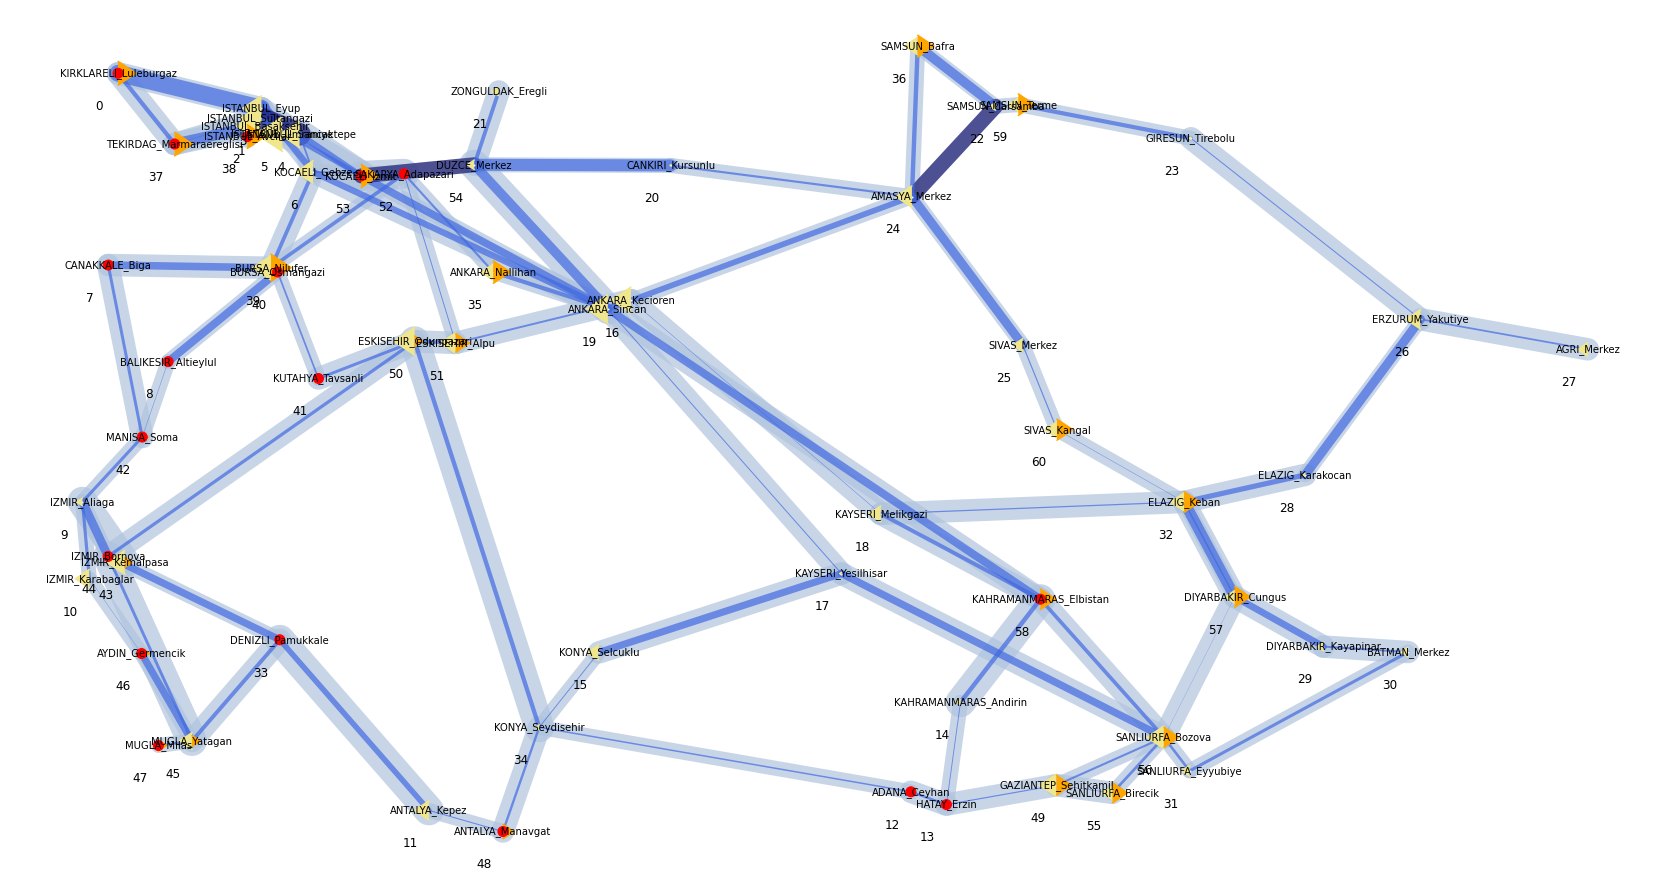

In [27]:
path = 'Results/Paper2_Workshop_Turkish/caseTurkish'
mat_file='results_caseTurkish_dataset_mpc'
file_directory='18+1/ExportedResults'#'caseTurkish_distributedStorages'
#file_directory='caseTurkish_StoragesCloseToLoad'
DCsOPF_file='Results_DCsOPF_NoStorage_local'
#DCsOPF_file='Results_DCsOPF_NoStorage_global'
#DCsOPF_file='Results_DCsOPF_Storage_local'
#DCsOPF_file='Results_DCsOPF_Storage_global'
#DCsOPF_file='Results_DCsOPF_Storage_local_withVariance'
#DCsOPF_file='Results_DCsOPF_Storage_global_withVariance'
plot_network_limits_RESULTS_FROM_JULIA(path, mat_file, file_directory, DCsOPF_file)

In [28]:
def plot_network_limits(mat_file='results_caseTurkish_dataset_mpc', name='caseTurkish_dataset', uncertainties=[59,47,55,41,52], storages=[4,6,7,8]):

    plt.rcParams['text.usetex'] = False
    
    # load capacities & .mat casefile
    df = data['capacity source type (MW)']
    mat = scipy.io.loadmat('casefiles/'+mat_file+'.mat')
    
    # create graph from .mat casefile
    case = ppc.from_mpc('casefiles/'+mat_file+'.mat')
    G = pp.topology.create_nxgraph(case)

    # extract buses, generators and branches
    mat_bus = mat['mpc'][0][0][2]
    mat_gen = mat['mpc'][0][0][3]
    mat_branch = mat['mpc'][0][0][4]
    
    # relabel indices
    # MATLAB (starts counting at 1) --> Python (starts counting at 0)
    mat_bus[:,0] = mat_bus[:,0].astype(int)-1
    mat_gen[:,0] = mat_gen[:,0].astype(int)-1
    mat_branch[:,[0,1]] = mat_branch[:,[0,1]].astype(int)-1 
    uncertainties = [u-1 for u in uncertainties]
    storages = [s-1 for s in storages]
    
    # ------------ LABELS (node names & nrs) --------------------
    G_nrs = G.copy()
    labels_nrs = {n : n for n in list(G.nodes)}
    G_nrs = nx.relabel_nodes(G_nrs, labels_nrs)
    labels_name = {n : bus_nr_to_dataset_names([n+1])[0] for n in list(G.nodes)}
    G = nx.relabel_nodes(G, labels_name)
    labels_nrs = {n : list(G_nrs.nodes)[i] for i,n in enumerate(list(G.nodes))}

    # ------------ COORDINATES --------------------
    # coordinates (names)
    coordinates_case = dict()
    for n in G.nodes:
        idx = df[df['Substation Nodes']==n].index[0]
        coordinates_case[n] = df.loc[idx, 'Longitude'], df.loc[idx, 'Latitude']
    coordinates_case = {e: coordinates_case[e] for e in list(np.unique(list(coordinates_case.keys())))}
    nx.set_node_attributes(G, coordinates_case, 'coord')
    
    # coordinates (numbers)
    coordinates_case_nrs = dict()
    for n in G_nrs.nodes:
        coordinates_case_nrs[n] = df.loc[n, 'Longitude'], df.loc[n, 'Latitude']
    coordinates_case_nrs = {e: coordinates_case_nrs[e] for e in list(np.unique(list(coordinates_case_nrs.keys())))}
    nx.set_node_attributes(G_nrs, coordinates_case_nrs, 'coord')

    # ------------ LOADS --------------------
    loads = mat_bus[:,2]
    loads_labels = {name : loads[nr].astype(int) for name,nr in zip(list(G.nodes), list(G_nrs.nodes))}
    node_size_loads = list(loads_labels.values())
    pos_labels = {k : (v[0]+0.2,v[1]+0.2) for k,v in coordinates_case.items()}
    pos_labels_nrs = {k : (v[0]-0.2,v[1]-0.2) for k,v in coordinates_case.items()}

    # ------------ GENERATION --------------------
    
    # generation
    gen = np.zeros(len(mat_bus))
    gen[mat_gen[:,0].astype(int)] = mat_gen[:,1]
    gen_labels = {nr : gen[nr] for nr in list(G_nrs.nodes)}
    node_size_gen = list(gen_labels.values())
    
    # max gen
    color1, color2 = 'orange', 'darkorange'
    gen_abs = mat_gen[:,1]
    gen_cap = mat_gen[:,8]
    max_gen = []
    j = 0
    for i in range(len(mat_bus)):
        if i in mat_gen[:,0].astype(int):
            if gen_abs[j] > gen_cap[j]*0.98:
                max_gen.append(color2)
            else:
                max_gen.append(color1)
            j = j+1
        else:
            max_gen.append(color1)
    max_gen

    # ------------ LINE FLOWs & CAPACITIES --------------------
    G_lines = nx.Graph()
    G_lines.add_nodes_from(G.nodes)
    
    # line flow
    c = 0.03
    line_flow = mat_branch[:,15]*c # flow fbus to tbus
    for i,e in enumerate(G.edges):
        G_lines.add_edge(e[0],e[1],weight=line_flow[i])
        
    # line capacities
    rateA = mat_branch[:,5] # rate A
    max_flow_ = [line_flow[i] > rateA[i]*0.98 for i in range(len(rateA))]
    max_flow = ['midnightblue' if e else 'royalblue' for e in max_flow_]
    
    # ------------ STORAGES & UNCERTAINTIES --------------------
    uncertainty_labels = DF(np.zeros(len(mat_bus)), index=list(G_nrs.nodes),columns=['0'])
    uncertainty_labels.loc[uncertainties] = 50
    storage_labels = DF(np.zeros(len(mat_bus)), index=list(G_nrs.nodes),columns=['0'])
    storage_labels.loc[storages] = 200

    # ============== PLOT ======================================
    plt.figure(figsize=(23,12)) 
    nx.draw(G, coordinates_case, node_color='lavender', with_labels=True, font_size=10, edge_color='lavender', font_color='k', node_size=1)
    #nx.draw_networkx_labels(G, pos_labels, labels=loads_labels, font_color='gray', font_size=20)
    nx.draw_networkx_labels(G, pos_labels_nrs, labels=labels_nrs)
    nx.draw_networkx_edges(G, coordinates_case, node_size=0, edge_color='lightsteelblue', width=rateA*c, alpha = 0.7)
    nx.draw_networkx_edges(G, coordinates_case, edge_color=max_flow, width=line_flow, alpha=0.7)
    nx.draw_networkx_nodes(G, coordinates_case, node_color='khaki', node_size=node_size_loads, node_shape=8) # 8 = triangle left
    nx.draw_networkx_nodes(G, coordinates_case, node_color=max_gen, node_size=node_size_gen, node_shape=9) # 9 = triangle right
    nx.draw_networkx_nodes(G, coordinates_case, node_size=storage_labels['0'], node_color='olive', node_shape='o')
    nx.draw_networkx_nodes(G, coordinates_case, node_size=uncertainty_labels['0'], node_color='white', node_shape='o') # '$unc.$'
    plt.title('Matpower results '+name)
    #plt.savefig(PATH_SAVE + '/'+name+'_OPF_results_loads_gen')
    plt.show()

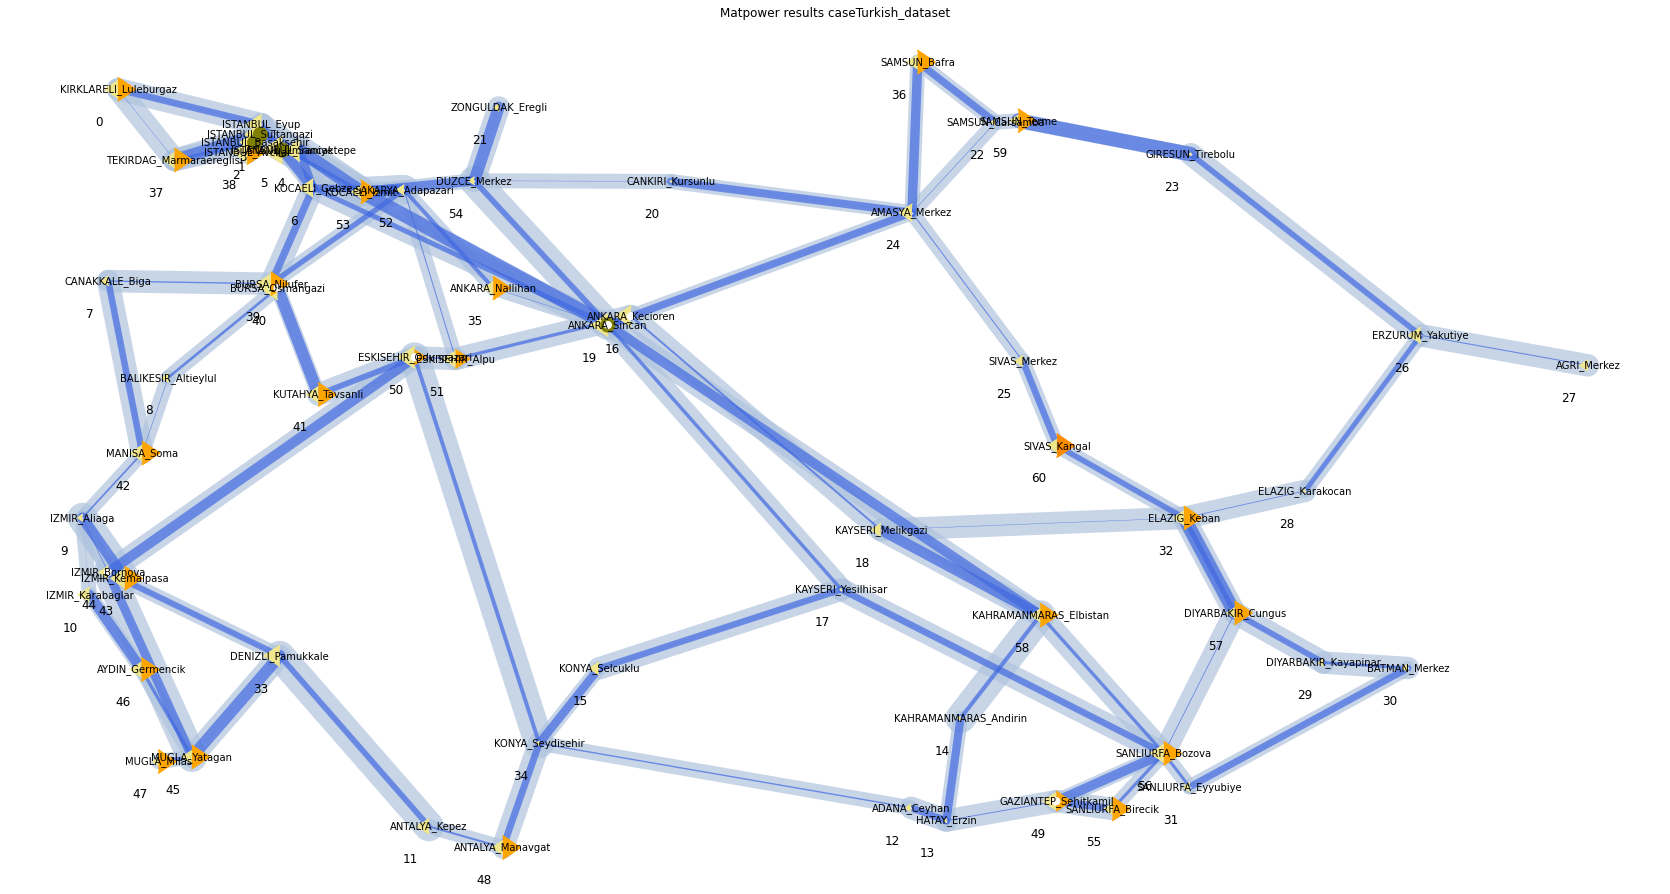

In [29]:
# load, gen capacity from dataset
name='caseTurkish_dataset'
mat_file='results_'+name+'_mpc'
plot_network_limits(mat_file, name, uncertainties=[51, 45, 20, 17, 50, 41], storages=[2,3,6,20])